In [10]:
import math
import numpy as np
from cv2 import Rodrigues
from math import sin, cos, atan2, sqrt
import pandas as pd
from pathlib import Path
import pyproj
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=Warning)
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding='ISO-8859-1', sep=';')
df

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27/12/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,...,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.0,1002.0
361,28/12/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,...,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0
362,29/12/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
363,30/12/2021,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,...,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6


In [5]:
msv = 2151264647
col1 = msv%16 + 1
col2 = msv%16 + 2
col3 = msv%16 + 3
print(col1)
print(col2)
print(col3)

8
9
10


In [6]:
df_sub = pd.concat([df["Ngày"], df["8"], df["9"], df["10"]], axis=1)
print(df_sub)

           Ngày       8       9      10
0    01/01/2021   964.4   964.4   964.4
1    01/02/2021  1019.7  1019.7  1019.7
2    01/03/2021   988.4   988.4   988.4
3    01/04/2021  1002.0  1002.1  1002.1
4    01/05/2021  1061.5  1061.5  1061.5
..          ...     ...     ...     ...
360  27/12/2021  1002.0  1002.0  1002.0
361  28/12/2021  1002.0  1002.0  1002.0
362  29/12/2021  1061.5  1061.5  1061.5
363  30/12/2021  1022.6  1022.6  1022.6
364  31/12/2021  1022.6  1022.6  1022.6

[365 rows x 4 columns]


In [7]:
df = df_sub

In [8]:
# Xem thông tin về dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ngày    365 non-null    object 
 1   8       365 non-null    float64
 2   9       365 non-null    float64
 3   10      365 non-null    float64
dtypes: float64(3), object(1)
memory usage: 11.5+ KB


In [9]:
# Thống kê mô tả
df.describe()

,8,9,10
count,365.000000,365.000000,365.000000
mean,1040.228219,1040.278082,1040.277808
std,105.147104,105.152979,105.153179
min,885.700000,885.700000,885.700000
25%,988.400000,988.400000,988.400000
50%,1022.600000,1022.600000,1022.600000
75%,1061.500000,1061.500000,1061.500000
max,1565.500000,1565.500000,1565.500000


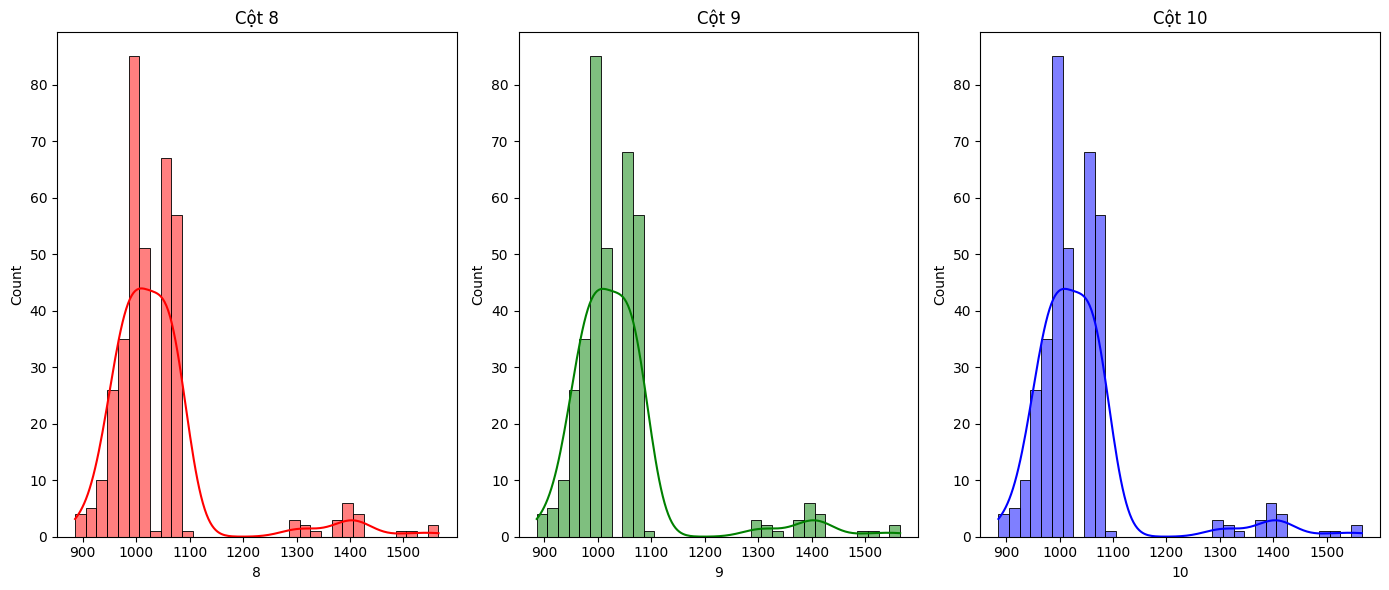

In [14]:
# Trực quan hóa phân phối của cột 8,9,10
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.histplot(data=df, x=df['8'], kde=True, color='red')
plt.title('Cột 8')

plt.subplot(1, 3, 2)
sns.histplot(data=df, x=df['9'], kde=True, color='green')
plt.title('Cột 9')

plt.subplot(1, 3, 3)
sns.histplot(data=df, x=df['10'], kde=True, color='blue')
plt.title('Cột 10')

plt.tight_layout()
plt.show()

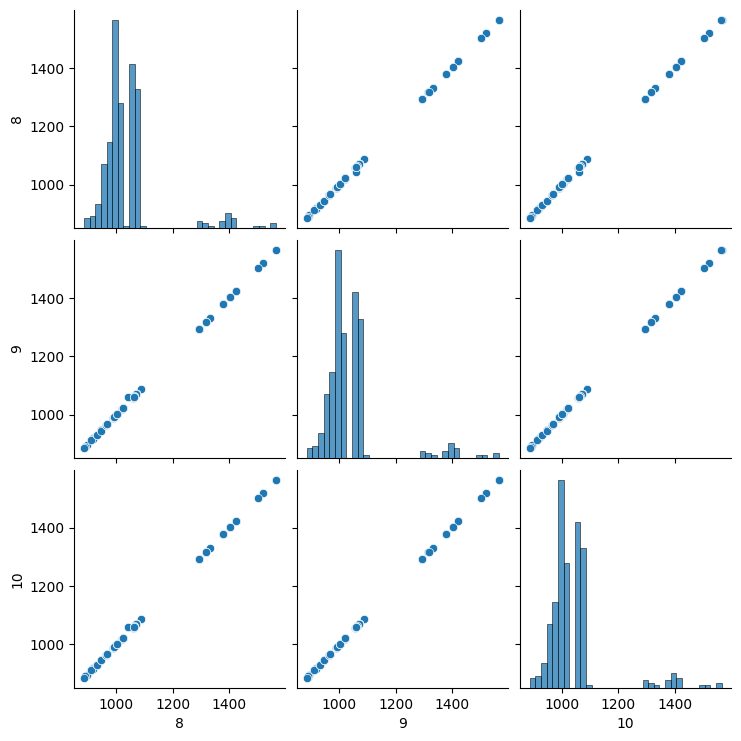

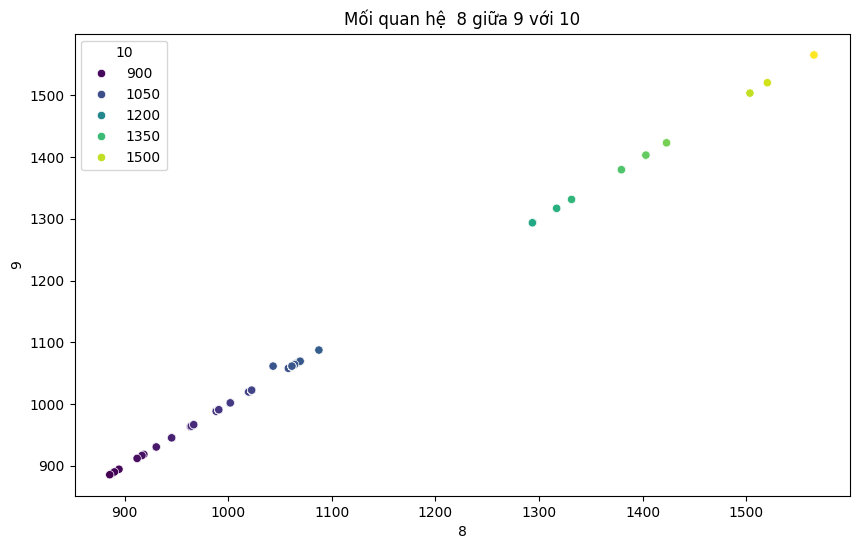

In [15]:
# Trực quan hóa mối quan hệ giữa các cột
sns.pairplot(df.iloc[:, [1, 2, 3]])
plt.show()

# Nếu muốn hiển thị các mối quan hệ trong cùng một biểu đồ với scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.iloc[:, 1], y=df.iloc[:, 2], hue=df.iloc[:, 3], palette='viridis')
plt.title('Mối quan hệ  ' + df.columns[1] + ' giữa ' + df.columns[2] + ' với ' + df.columns[3])
plt.xlabel(df.columns[1])
plt.ylabel(df.columns[2])
plt.show()

In [24]:
pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=cf15364d7217efb867f65f81754002d56506e95dca81518f93e9094ed05135d2
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [17]:
X = df.iloc[:, [1, 2, 3]].values

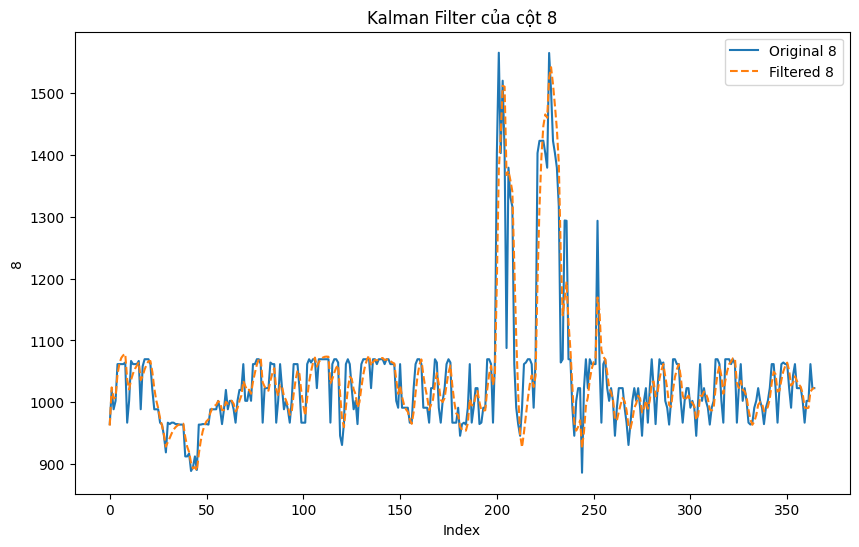

In [25]:
from filterpy.kalman import KalmanFilter
import numpy as np

# Function to apply Kalman Filter
def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = np.array([[0.1, 0.1], [0.1, 0.1]])

    filtered_data = []
    for z in data:
        kf.predict()
        kf.update(z)
        filtered_data.append(kf.x[0])
    return filtered_data

# Áp dụng Kalman Filter cho cột thứ 8 (Feature_5)
filtered_feature_8 = apply_kalman_filter(X[:, 0])

# So sánh dữ liệu gốc và dữ liệu đã lọc
plt.figure(figsize=(10, 6))
plt.plot(X[:, 0], label='Original ' + df.columns[1])
plt.plot(filtered_feature_8, label='Filtered ' + df.columns[1], linestyle='dashed')
plt.title('Kalman Filter của cột ' + df.columns[1])
plt.xlabel('Index')
plt.ylabel(df.columns[1])
plt.legend()
plt.show()

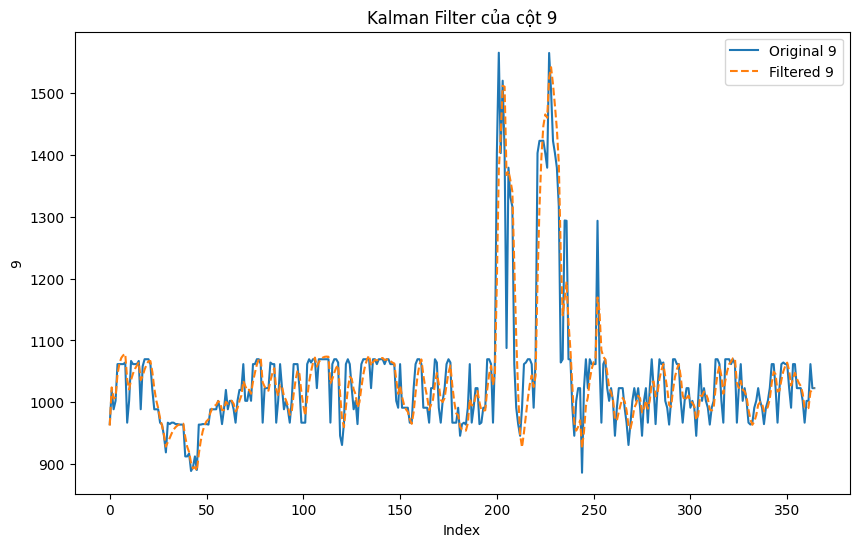

In [28]:
def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = np.array([[0.1, 0.1], [0.1, 0.1]])

    filtered_data = []
    for z in data:
        kf.predict()
        kf.update(z)
        filtered_data.append(kf.x[0])
    return filtered_data
filtered_feature_9 = apply_kalman_filter(X[:, 2])
plt.figure(figsize=(10, 6))
plt.plot(X[:, 1], label='Original ' + df.columns[2])
plt.plot(filtered_feature_9, label='Filtered ' + df.columns[2], linestyle='dashed')
plt.title('Kalman Filter của cột ' + df.columns[2])
plt.xlabel('Index')
plt.ylabel(df.columns[2])
plt.legend()
plt.show()

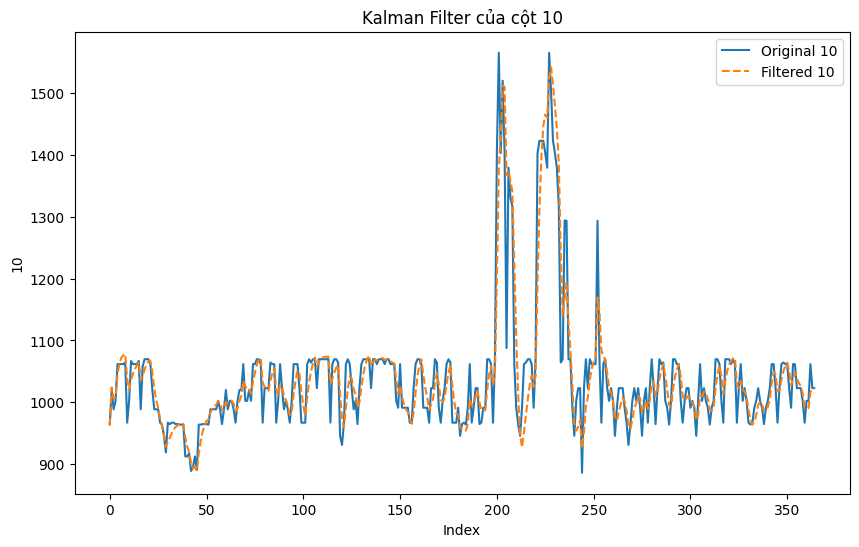

In [29]:
# Function to apply Kalman Filter
def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = np.array([[0.1, 0.1], [0.1, 0.1]])

    filtered_data = []
    for z in data:
        kf.predict()
        kf.update(z)
        filtered_data.append(kf.x[0])
    return filtered_data

filtered_feature_10 = apply_kalman_filter(X[:, 2])

plt.figure(figsize=(10, 6))
plt.plot(X[:, 1], label='Original ' + df.columns[3])
plt.plot(filtered_feature_10, label='Filtered ' + df.columns[3], linestyle='dashed')
plt.title('Kalman Filter của cột ' + df.columns[3])
plt.xlabel('Index')
plt.ylabel(df.columns[3])
plt.legend()
plt.show()

MAE for column 1: 33.50032935532035
MAE for column 2: 33.650769314833546
MAE for column 3: 33.651595761114535


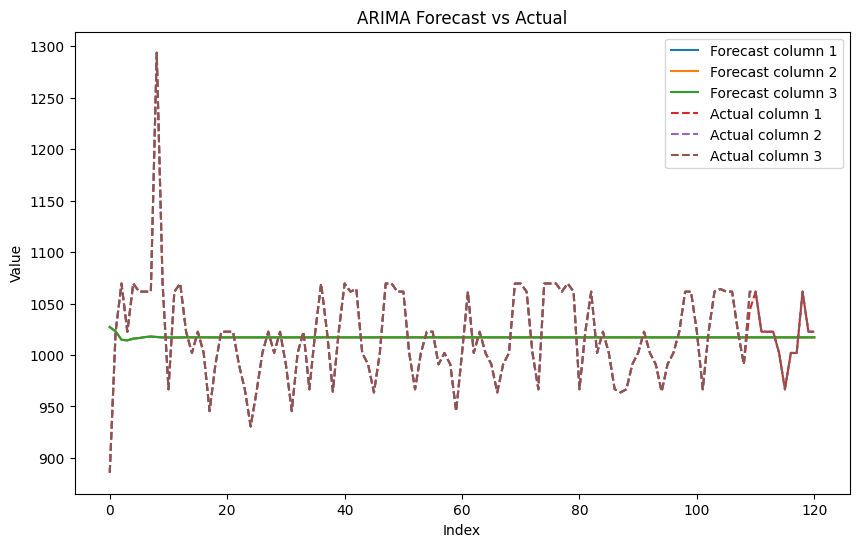

In [38]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Assuming df is your DataFrame and X is the subset of columns you want to use

# Extracting the subset of columns for modeling
X = df.iloc[:, [1, 2, 3]].values

# Splitting data into training and testing sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]

# Fit ARIMA models for each column separately
orders = [(5, 1, 0), (5, 1, 0), (5, 1, 0)]  # Example orders, you can tune these
model_fits = []
for i in range(X_train.shape[1]):  # Iterate over columns
    model = ARIMA(X_train[:, i], order=orders[i])
    model_fit = model.fit()
    model_fits.append(model_fit)

# Forecasting for each column
forecasts = []
for model_fit in model_fits:
    forecast = model_fit.forecast(steps=len(X_test))
    forecasts.append(forecast)

# Evaluate your models
mae_scores = []
for i, forecast in enumerate(forecasts):
    mae = mean_absolute_error(X_test[:, i], forecast)
    mae_scores.append(mae)
    print(f"MAE for column {i+1}: {mae}")

# Optionally, you can visualize the forecasts and actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, forecast in enumerate(forecasts):
    plt.plot(forecast, label=f"Forecast column {i+1}")

for i in range(X_test.shape[1]):
    plt.plot(X_test[:, i], label=f"Actual column {i+1}", linestyle='dashed')

plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()
